# Explicação
Nesse arquivo há:
- Limpeza de dados usados para a classificação.
- Uma breve análise desses dados.

In [2]:
from astropy.stats import sigma_clip, mad_std
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# From: https://github.com/marixko/MNRAS_nakazono_2021

def apply_sigma_clip(data, mag_splus, mag_sdss, sigma_value=4):
    '''
    Apply n-sigma clipping on the S-PLUS and SDSS magnitude difference per 
    magnitude (from S-PLUS) bin of size 0.5 
    
    Keywords arguments:
    data -- full dataset
    mag_splus -- magnitude from S-PLUS
    mag_sdss -- magnitude from SDSS
    sigma_value -- value of n (default: 4)
    create_plot -- determine if plot of mag_sdss - mag_splus x mag_splus is created
    
    returns a subset from data that pass through n-sigma clipping
    '''
    aux2 = data
    final_data = pd.DataFrame([])
    for i in np.arange(np.floor(np.min(data.query(mag_splus+'!=99 and '+mag_splus+'!=-99')[mag_splus])), np.ceil(np.max(data.query(mag_splus+'!=99 and '+mag_splus+'!=-99')[mag_splus])), 0.5):
        aux = aux2[(aux2[mag_splus] > i) & (aux2[mag_splus] <= i+0.5)].query(mag_sdss+'< 90 and '+mag_sdss+"> -90 and "+mag_splus+" <90")
        filtered_data = sigma_clip(
            aux[mag_sdss]-aux[mag_splus], sigma=sigma_value, maxiters=5, stdfunc=mad_std, return_bounds=True)
        if len(filtered_data) != 0:
            final_data = pd.concat(
                [final_data, aux[filtered_data[0].mask == False]], axis=0)

    return final_data

In [4]:
QSO = Table.read("QSO_S82_iDR4.fits", format='fits')
QSO = QSO.to_pandas().assign(target=0).rename(columns={"r":"modelmag_r"})

STAR = Table.read("STAR_S82_iDR4.fits", format='fits')
STAR = STAR.to_pandas().assign(target=1)

GAL = Table.read("GALAXY_S82_iDR4.fits", format='fits')
GAL = GAL.to_pandas().assign(target=2)

In [5]:
columns = ['ID','RA_1', 'DEC_1', 'u_iso', 'J0378_iso', 'J0395_iso', 'J0410_iso', 'J0430_iso',
       'g_iso', 'J0515_iso', 'r_iso', 'J0660_iso', 'i_iso',
       'J0861_iso', 'z_iso', 'target', 'e_r_iso', 'FWHM_n', 'w1mpro', 'w2mpro'] 

QSO = QSO[(QSO['SEX_FLAGS_r'] == 0) & (QSO['r_iso']<=22)]
STAR = STAR[(STAR['SEX_FLAGS_r'] == 0) & (STAR['r_iso']<=22) & (STAR['r_iso']>13)]
GAL = GAL[(GAL['SEX_FLAGS_r'] == 0) & (GAL['r_iso']<=22) & (GAL['zWarning']==0)]

total = pd.concat([QSO,STAR,GAL])
total = apply_sigma_clip(total, 'r_iso', 'modelmag_r',)
total = total[columns].reset_index().drop(columns='index')

### Observação:
Aqui, eu utilizo as magnitudes do wise para obter a mesma divisão treino/testo do classificador atual do DR4.
O processo utilizado antes foi o seguinte:
 - Separar os dados em dois conjuntos disjuntos: os que possuem observação no WISE e os que não possuem.
 - Para cada conjunto, separar treino/teste com 25% para teste.
 - Unir, novamente, os conjuntos.

Como eu não tenho nenhuma garantia (e, por uma observação feita enquanto reproduzia o artigo da Lilianne, tenho conviccção de que não) de que $split(a) + split(b) = split(a+b)$, vou usar as colunas do WISE para fazer o mesmo processo. Embora o WISE não possua significado nesse contexto, farei isso apenas para assegurar a mesma divisão.

In [6]:
from sklearn.model_selection import train_test_split

with_wise = total[~total["w1mpro"].isna() & ~total["w2mpro"].isna()] 

target = with_wise["target"]
X_train_wise, X_test_wise, y_train_wise, y_test_wise = train_test_split(with_wise, target,test_size=0.25,random_state=2,stratify=target)

In [7]:
no_wise =  total.merge(with_wise, how='left', indicator=True)
no_wise = no_wise[no_wise['_merge'] == 'left_only']
target = no_wise["target"]
X_train_no_wise, X_test_no_wise, y_train_no_wise, y_test_no_wise = train_test_split(no_wise, target,test_size=0.25,random_state=2,stratify=target)

In [8]:
X_train_total = pd.concat([X_train_wise,X_train_no_wise]).assign(test=0)
X_test_total = pd.concat([X_test_wise, X_test_no_wise]).assign(test=1, train=0, validation=0)

### Observações: 
Agora, temos a seguinte propriedade: \
Para um objeto $o$, se $o['test'] = 1$, então $o$ estava no conjunto de testes do modelo treinado para o DR4. A recíproca também vale.


Agora, irei definir um conjunto de validação. Esse conjunto não está relacionado com o modelo treinado para o DR4, então não precisarei utilizar as informações do WISE. O conjunto de validação pegará 20% de X_train_total (que possui 75% de todos os dados). \
\
Logo, o split será:
 - Treino: 60%
 - Validação: 15%
 - Teste: 25%

Esse split é apenas inicial e pode mudar no futuro.



In [9]:
target = X_train_total["target"]
X_train, X_val, y_train, y_val = train_test_split(X_train_total, target,test_size=0.20,random_state=2,stratify=target)

In [10]:
X_train = X_train.assign( train=1, validation=0)
X_val = X_val.assign(train=0, validation=1)

In [22]:
final = pd.concat([X_train, X_val, X_test_total]).drop(columns="_merge")

In [23]:
final['ID'] = final['ID'].str.decode('utf-8').str[2:30] 
final = final.drop_duplicates(subset="ID") # Retira uma versão de objetos com classificação multipla
final = final[(final.ID != 'iDR4_3_STRIPE82-0066_0044492')
             &(final.ID != 'iDR4_3_STRIPE82-0046_0029265')]# Retira dois objetos que (por algum motivo) não estão sendo baixados.

## Visualizações:

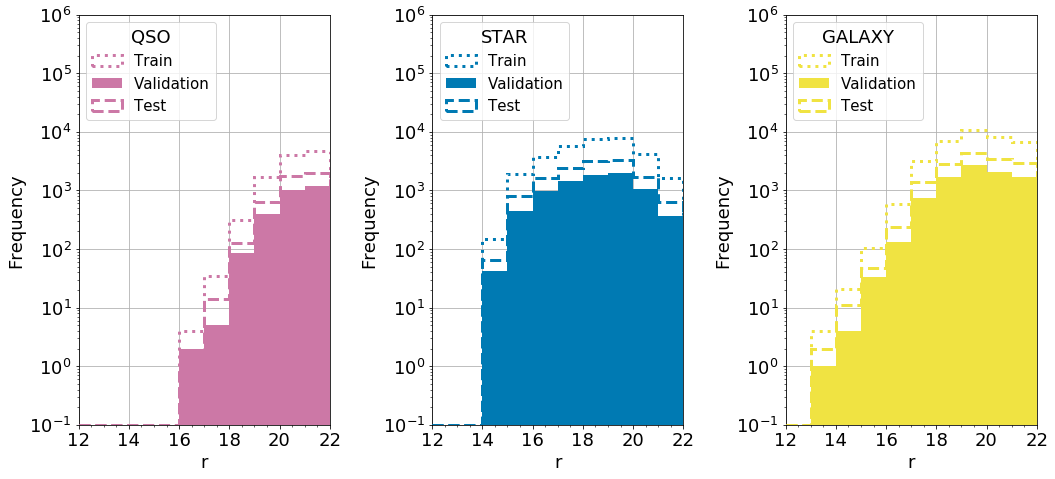

In [24]:
# Adaptado de https://github.com/marixko/MNRAS_nakazono_2021/blob/main/Nakazono_et_al_2021.ipynb

blue = (0, 0.48, 0.70)
orange = (230/255,159/255, 0)
yellow = (0.94, 0.89, 0.26)
pink = (0.8, 0.47, 0.65)

plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(1,3, figsize=(15,7))

bins = np.arange(12,22.1,1)
log = True
density = False
ax[0].hist(final[(final.target==0) & (final.train==1)].r_iso, histtype="step", linewidth=3, linestyle="dotted", bins=bins,
             color=pink, log=log, density=density, label="Train", zorder=3)
ax[0].hist(final[(final.target==0) & (final.validation==1)].r_iso, bins=bins, color=pink, log=log, density=density, label="Validation", zorder=3)
ax[0].hist(final[(final.target==0) & (final.test==1)].r_iso, histtype="step", linewidth=3, linestyle="dashed", bins=bins,
             color=pink, log=log, density=density, label="Test", zorder=3)

ax[1].hist(final[(final.target==1) & (final.train==1)].r_iso, histtype="step", linewidth=3, linestyle="dotted", bins=bins,
             color=blue, log=log, density=density, label="Train", zorder=3)
ax[1].hist(final[(final.target==1) & (final.validation==1)].r_iso, bins=bins, color=blue, log=log, density=density, label="Validation", zorder=3)
ax[1].hist(final[(final.target==1) & (final.test==1)].r_iso, histtype="step", linewidth=3, linestyle="dashed", bins=bins,
             color=blue, log=log, density=density, label="Test", zorder=3)


ax[2].hist(final[(final.target==2) & (final.train==1)].r_iso, histtype="step", linewidth=3, linestyle="dotted", bins=bins,
             color=yellow, log=log, density=density, label="Train", zorder=3)
ax[2].hist(final[(final.target==2)& (final.validation==1)].r_iso, bins=bins, color=yellow, log=log, density=density, label="Validation", zorder=3)
ax[2].hist(final[(final.target==2) & (final.test==1)].r_iso, histtype="step", linewidth=3, linestyle="dashed", bins=bins,
             color=yellow, log=log, density=density, label="Test", zorder=3)



for j in [0,1,2]:
    if j == 0:
        title="QSO"
    elif j == 1:
        title="STAR"
    else:
        title ="GALAXY"
    
    ax[j].minorticks_on()
    ax[j].grid(zorder=0)
    ax[j].set_xticks(np.arange(12,22.1,2))
    ax[j].legend(loc="upper left", title=title, prop={'size': 15}, title_fontsize=18)
        
plt.setp(ax, xlim=(12,22), ylim=(0.1,1000000) ,xlabel='r', ylabel = "Frequency")
plt.tight_layout()

In [25]:
print(f"Existem {len(final[final.r_iso<=14])} objetos com magnitude <= 14")
for i in range(15,23):
    print(f"Existem {len(final[(final.r_iso>i-1)&(final.r_iso<=i)])} objetos com magnitude {i-1}<r<={i}")

Existem 7 objetos com magnitude <= 14
Existem 291 objetos com magnitude 14<r<=15
Existem 3308 objetos com magnitude 15<r<=16
Existem 7327 objetos com magnitude 16<r<=17
Existem 14803 objetos com magnitude 17<r<=18
Existem 24564 objetos com magnitude 18<r<=19
Existem 33546 objetos com magnitude 19<r<=20
Existem 27330 objetos com magnitude 20<r<=21
Existem 21955 objetos com magnitude 21<r<=22


## Análise da Distribuição de magnitude

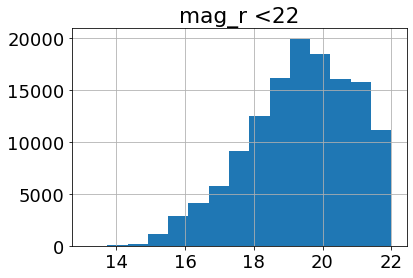

In [26]:
plt.title("mag_r <22")
total.r_iso.hist(bins=15)

In [27]:
teste = total[total.e_r_iso <0.05]
print(f"{len(total)-len(teste)} objetos foram eliminados")

54650 objetos foram eliminados


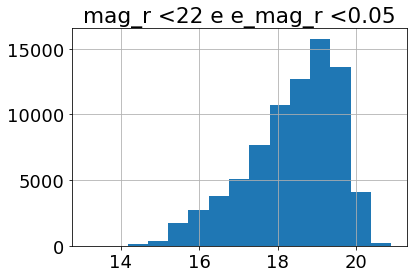

In [28]:
plt.title("mag_r <22 e e_mag_r <0.05")
teste.r_iso.hist(bins=15)

# Salvando em csv

In [29]:
final.reset_index().drop(columns='index').to_csv("clf.csv")

In [30]:
final

,ID,RA_1,DEC_1,u_iso,J0378_iso,J0395_iso,J0410_iso,J0430_iso,g_iso,J0515_iso,...,J0861_iso,z_iso,target,e_r_iso,FWHM_n,w1mpro,w2mpro,test,train,validation
40573,iDR4_3_STRIPE82-0062_0018609,41.737552,0.709117,22.803257,21.570564,20.394072,22.049292,22.172140,19.920929,20.161518,...,17.356270,17.337421,1,0.023448,1.011161,14.946,14.820,0,1,0
3976,iDR4_3_STRIPE82-0015_0005352,9.796036,-1.214655,17.553290,17.087702,17.032228,16.685562,16.612263,16.389988,16.269800,...,15.967942,15.990722,1,0.004742,1.005735,14.865,14.821,0,1,0
53724,iDR4_3_STRIPE82-0033_0036855,23.119002,-0.159082,23.591427,22.685244,20.671950,20.825050,20.590600,20.480804,20.199745,...,18.163343,18.066355,1,0.027075,0.966917,15.743,15.984,0,1,0
38856,iDR4_3_STRIPE82-0020_0033506,12.821747,0.961903,99.000000,22.702345,99.000000,20.625496,21.230413,20.072119,20.190523,...,17.415493,17.328402,1,0.020592,1.097667,14.975,15.142,0,1,0
980,iDR4_3_STRIPE82-0109_0077952,316.226422,-0.062439,17.282547,16.964577,16.715021,16.180395,16.062126,15.601593,15.424949,...,14.789743,14.747582,1,0.001591,1.034177,13.365,13.418,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128428,iDR4_3_STRIPE82-0047_0010400,32.786951,-0.958955,22.498566,22.507536,25.487170,23.579075,99.000000,21.969496,22.139929,...,21.570396,21.504948,1,0.208099,2.577389,NaN,NaN,1,0,0
115669,iDR4_3_STRIPE82-0026_0023742,17.528267,0.607531,23.519619,22.462156,21.948318,22.559492,22.507400,22.022938,21.708664,...,20.602158,21.504713,1,0.089766,1.042697,NaN,NaN,1,0,0
127151,iDR4_3_STRIPE82-0120_0002848,323.358781,0.105739,26.210192,22.238020,99.000000,99.000000,21.963196,21.908920,21.698889,...,21.907974,21.229853,0,0.244746,2.489914,NaN,NaN,1,0,0
58739,iDR4_3_STRIPE82-0005_0027984,2.934505,-0.395609,20.452728,20.890343,20.756990,21.070818,20.414760,19.983166,19.931622,...,18.965235,18.848484,2,0.046375,2.068884,NaN,NaN,1,0,0
